# Load the datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

orders_df = pd.read_excel('Analyst_Assignment.xlsx', sheet_name='sample_customer_orders')
mapping_df = pd.read_excel('Analyst_Assignment.xlsx', sheet_name='sampleProductMapping')

# Data preparation

In [2]:
#  Prepare the orders data
# Rename vendor to brand (if needed) to match assignment terminology
orders_df.rename(columns={'vendor': 'brand'}, inplace=True)

# Convert order date column to datetime
orders_df["Order_date"] = pd.to_datetime(orders_df["Order_date"])

# Convert productId to string to ensure proper matching (if necessary)
orders_df["productId"] = orders_df["productId"].astype('Int64')
mapping_df["sampleProductId"] = mapping_df["sampleProductId"].astype('Int64')
mapping_df["parentProductId"] = mapping_df["parentProductId"].astype('Int64')


In [3]:
# Flag orders that are samples or parent product purchases
orders_df['is_sample'] = orders_df['productId'].isin(mapping_df['sampleProductId'])
orders_df['is_parent'] = orders_df['productId'].isin(mapping_df['parentProductId'])


In [4]:
orders_df.to_excel("final_data.xlsx", index=False)

In [5]:
#sample_orders = orders_df[orders_df["is_sample"]].copy()
#non_sample_orders = orders_df[~orders_df["is_sample"]].copy()
#sample_orders.shape

# Separate sample orders from the rest for analysis using multiple criteria

In [6]:

sample_orders = orders_df[
    (orders_df["is_sample"]) |
    (orders_df["productType"].str.lower() == "sample") |
    (orders_df["productName"].str.contains("sample", case=False, na=False))
].copy()

non_sample_orders = orders_df[~(
    (orders_df["is_sample"]) |
    (orders_df["productType"].str.lower() == "sample") |
    (orders_df["productName"].str.contains("sample", case=False, na=False))
)].copy()

In [7]:
sample_orders.shape

(89789, 12)

# TASK 1: Analyze Brand Attachment

In [8]:

# For each sample order, check if the same customer purchased another product from the same brand later.
def brand_conversion(row):
    cust = row['customer_id']
    brand = row['brand']
    sample_date = row['Order_date']
    # Filter non-sample orders for same customer and same brand with a later order date
    subsequent_orders = non_sample_orders[
        (non_sample_orders['customer_id'] == cust) &
        (non_sample_orders['brand'] == brand) &
        (non_sample_orders['Order_date'] > sample_date)
    ]
    return len(subsequent_orders) > 0

sample_orders['brand_converted'] = sample_orders.apply(brand_conversion, axis=1)

# Calculate overall brand conversion rate (attachment)
brand_conversion_rate = sample_orders['brand_converted'].mean()
print(f"Overall Brand Conversion Rate: {brand_conversion_rate:.2%}")


Overall Brand Conversion Rate: 25.68%


In [9]:
# Optional: Group by brand to see conversion rates per brand
brand_conversion_summary = sample_orders.groupby('brand')['brand_converted'].agg(['mean', 'count'])
print("\nBrand Conversion Summary:")
print(brand_conversion_summary)



Brand Conversion Summary:
                   mean  count
brand                         
A plus A pets  0.000000      7
Aeolus         0.000000      3
Applaws        0.184211    190
BLEP           0.044586    314
Bark Out Loud  0.050615   1383
...                 ...    ...
Trixie         0.183727    381
Wahl           0.000000      8
Whiskas        0.796694    605
Wiggles        0.500000      2
Woofur         0.000000      3

[114 rows x 2 columns]


# TASK 2: Analyze Product Attachment

In [10]:

# Merge sample orders with mapping data to retrieve the corresponding parentProductId for each sample order.
sample_orders = sample_orders.merge(mapping_df, left_on='productId', right_on='sampleProductId', how='left')

def product_conversion(row):
    cust = row['customer_id']
    parent_id = row['parentProductId']
    sample_date = row['Order_date']
    # Find subsequent orders by the same customer that purchased the parent product
    subsequent_parent_order = non_sample_orders[
        (non_sample_orders['customer_id'] == cust) &
        (non_sample_orders['productId'] == parent_id) &
        (non_sample_orders['Order_date'] > sample_date)
    ]
    return len(subsequent_parent_order) > 0

sample_orders['product_converted'] = sample_orders.apply(product_conversion, axis=1)
product_conversion_rate = sample_orders['product_converted'].mean()
print(f"\nOverall Product Conversion Rate: {product_conversion_rate:.2%}")



Overall Product Conversion Rate: 3.29%


In [11]:
# Optional: Group by sample product (sampleProductId) to see conversion rates per product
product_conversion_summary = sample_orders.groupby('sampleProductId')['product_converted'].agg(['mean', 'count'])
print("\nProduct Conversion Summary:")
print(product_conversion_summary)


Product Conversion Summary:
                     mean  count
sampleProductId                 
7628490703086    0.032407    216
7628632129774    0.000000      1
7680873595118    0.003711    539
7699368837358    0.028571     35
7699376701678    0.000000     35
...                   ...    ...
8524215320814    0.000000      1
8524220072174    0.000000      8
8537778880750    0.000000     13
8546573156590    0.000000     27
8550403768558    0.000000     10

[286 rows x 2 columns]


# TASK 3: Calculate Time to Conversion

In [12]:

# For each sample order, calculate the time difference to the first parent product purchase.
def conversion_time_hours(row):
    cust = row['customer_id']
    parent_id = row['parentProductId']
    sample_date = row['Order_date']
    # Filter for parent product purchases after the sample date
    subsequent_parent_orders = non_sample_orders[
        (non_sample_orders['customer_id'] == cust) &
        (non_sample_orders['productId'] == parent_id) &
        (non_sample_orders['Order_date'] > sample_date)
    ]
    if subsequent_parent_orders.empty:
        return np.nan
    else:
        # Get the earliest conversion time (in hours)
        min_time = (subsequent_parent_orders['Order_date'] - sample_date).min()
        return min_time.total_seconds() / 3600  # conversion time in hours

sample_orders['conversion_time_hours'] = sample_orders.apply(conversion_time_hours, axis=1)

# Calculate average conversion time (excluding orders with no conversion)
average_conversion_time_hours = sample_orders['conversion_time_hours'].dropna().mean()
print(f"\nAverage Conversion Time: {average_conversion_time_hours:.2f} hours")




Average Conversion Time: 2263.65 hours


In [13]:
# Optionally, you can also convert hours to days if preferred:
average_conversion_time_days = average_conversion_time_hours / 24
print(f"Average Conversion Time: {average_conversion_time_days:.2f} days")

Average Conversion Time: 94.32 days


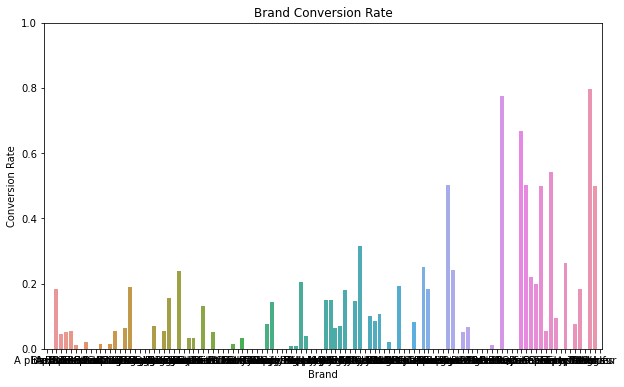

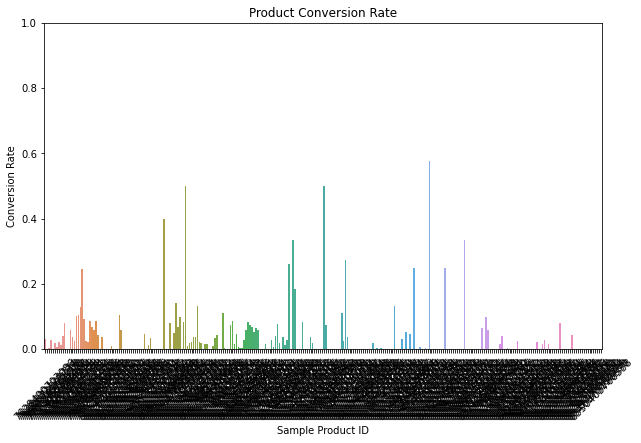

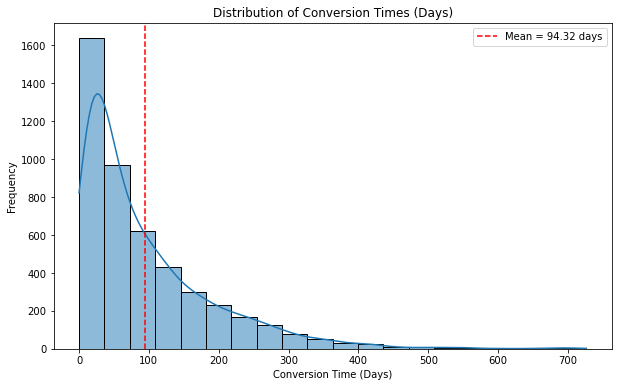

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization 1: Brand Conversion Rate
plt.figure(figsize=(10, 6))
# Group by brand and compute conversion rate
brand_conversion_summary = sample_orders.groupby('brand')['brand_converted'].agg(['mean', 'count']).reset_index()
sns.barplot(x='brand', y='mean', data=brand_conversion_summary)
plt.title('Brand Conversion Rate')
plt.xlabel('Brand')
plt.ylabel('Conversion Rate')
plt.ylim(0, 1)
plt.show()

# Visualization 2: Product Conversion Rate
plt.figure(figsize=(10, 6))
# Group by sample product id and compute conversion rate
product_conversion_summary = sample_orders.groupby('sampleProductId')['product_converted'].agg(['mean', 'count']).reset_index()
sns.barplot(x='sampleProductId', y='mean', data=product_conversion_summary)
plt.title('Product Conversion Rate')
plt.xlabel('Sample Product ID')
plt.ylabel('Conversion Rate')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

# Visualization 3: Distribution of Conversion Times (in Days)
plt.figure(figsize=(10, 6))
# Convert conversion times from hours to days (drop NaNs)
conversion_times_days = sample_orders['conversion_time_hours'].dropna() / 24
sns.histplot(conversion_times_days, kde=True, bins=20)
mean_conversion_days = conversion_times_days.mean()
plt.axvline(mean_conversion_days, color='red', linestyle='--', label=f'Mean = {mean_conversion_days:.2f} days')
plt.title('Distribution of Conversion Times (Days)')
plt.xlabel('Conversion Time (Days)')
plt.ylabel('Frequency')
plt.legend()
plt.show()
